# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

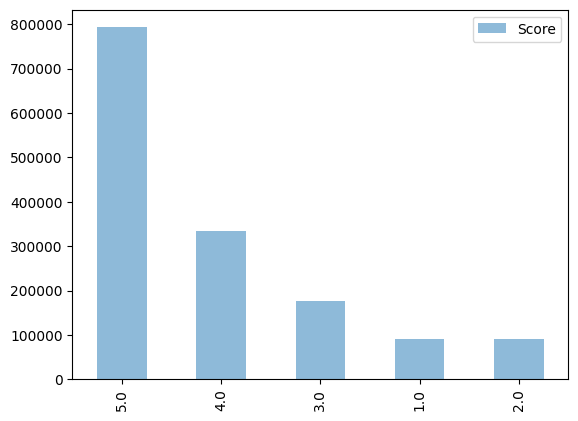


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

In [172]:
# Print all details of the training set for certain rows
print(trainingSet.iloc[1100:1120].to_string())

           Id   ProductId          UserId  HelpfulnessNumerator  HelpfulnessDenominator        Time                                                             Summary                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Experiment with Relationships Between Existing Features

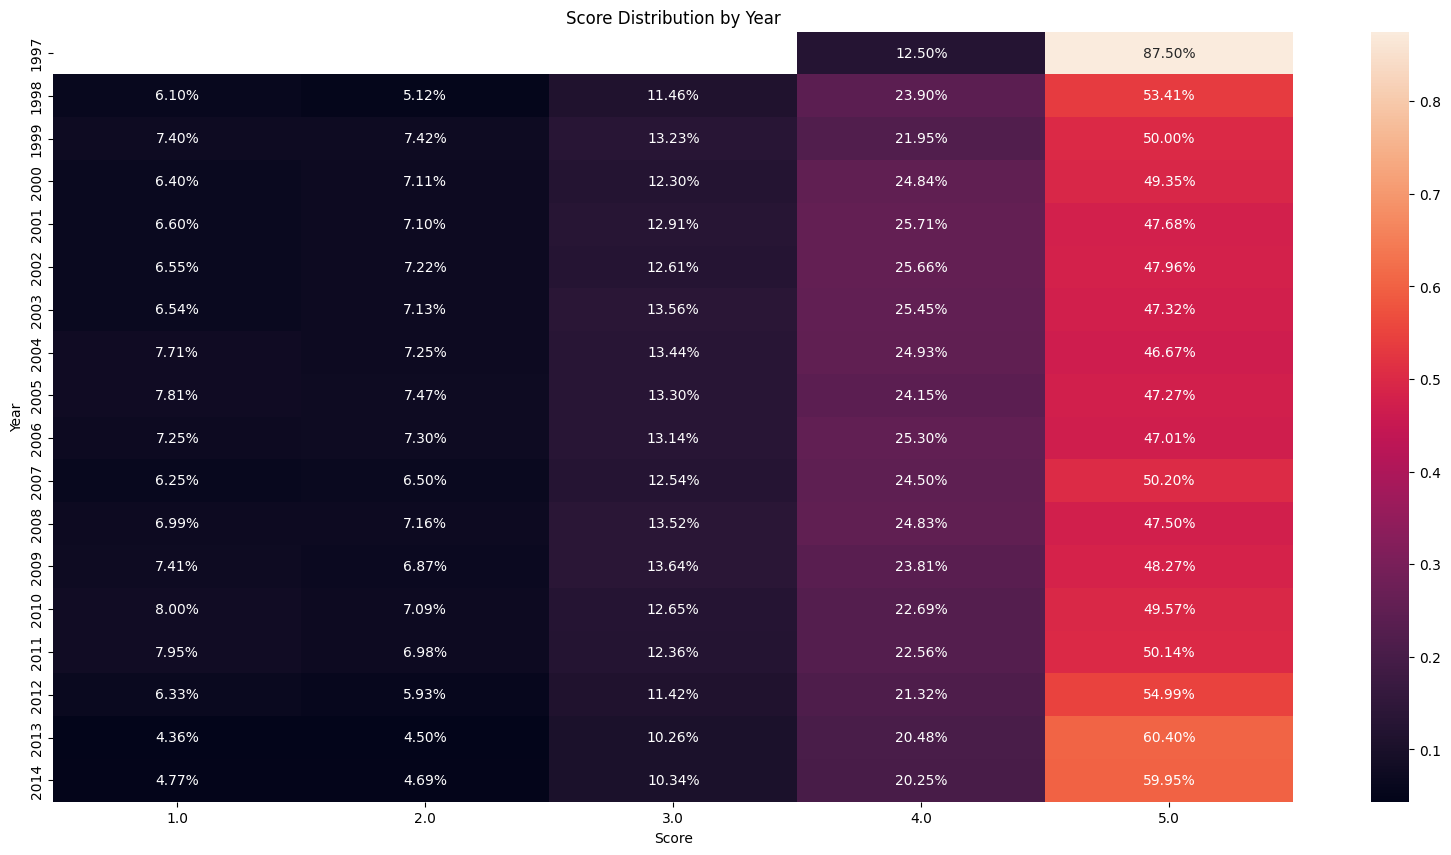

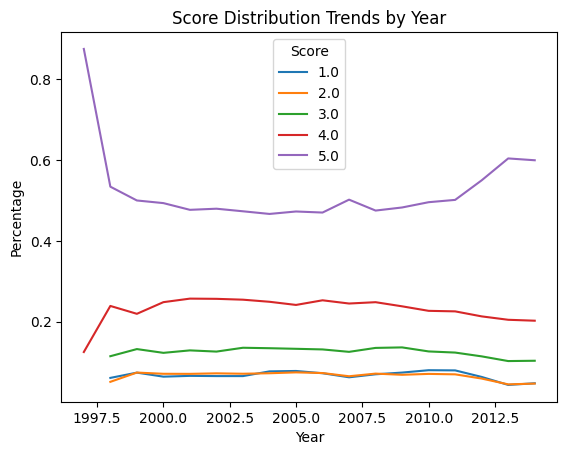

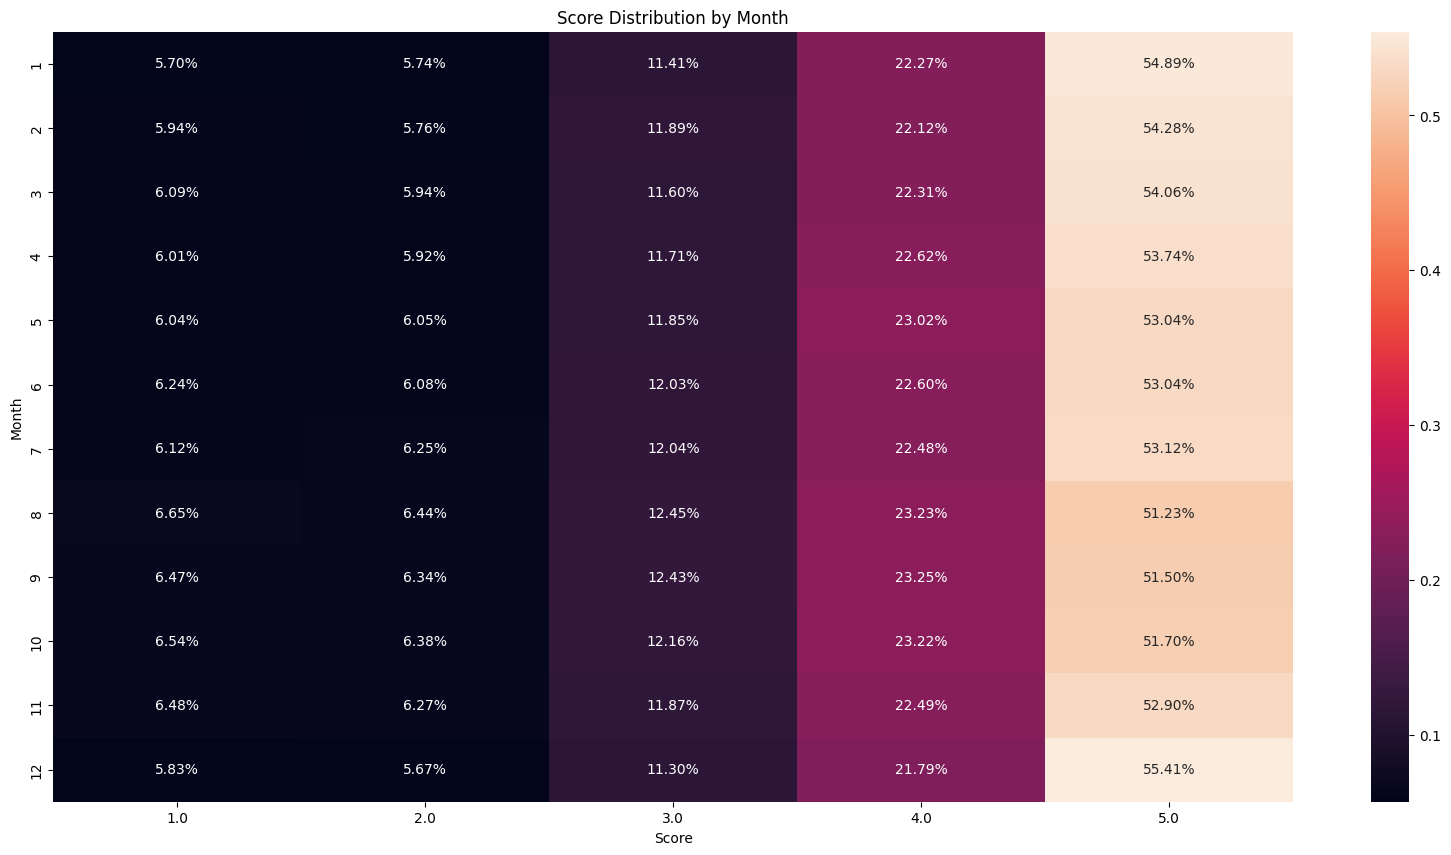

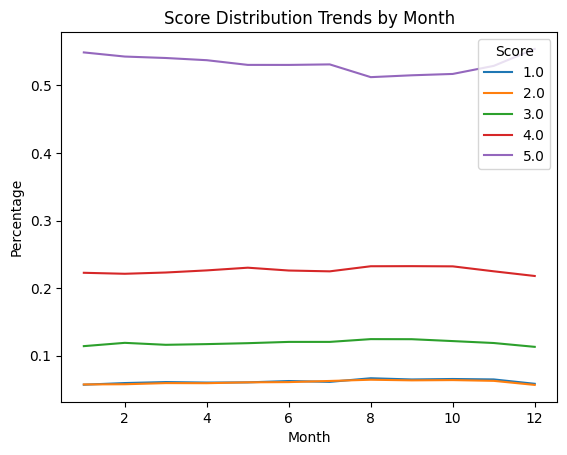

In [173]:

def process_timestamp(df, time_col='Time'):
    df['Year'] = pd.to_datetime(df[time_col], unit='s', errors='coerce').dt.year
    df['Month'] = pd.to_datetime(df[time_col], unit='s', errors='coerce').dt.month

def plot_heatmap(df, time_col, score_col, figsize=(20, 10), normalize=True):
    data = df.groupby([time_col, score_col]).size().unstack()
    if normalize:
        data = data.apply(lambda x: x / x.sum(), axis=1)
    plt.figure(figsize=figsize)
    sns.heatmap(data, annot=True, fmt='.2%' if normalize else 'd')
    plt.title(f'{score_col} Distribution by {time_col}')
    plt.show()

def plot_line_chart(df, time_col, score_col, normalize=True):
    data = df.groupby([time_col, score_col]).size().unstack()
    if normalize:
        data = data.apply(lambda x: x / x.sum(), axis=1)
    data.plot()
    plt.title(f'{score_col} Distribution Trends by {time_col}')
    plt.ylabel('Percentage' if normalize else 'Count')
    plt.xlabel(time_col)
    plt.show()

def run__time_score_relationship_analysis(df, time_col='Time', score_col='Score'):
    process_timestamp(df, time_col=time_col)
    plot_heatmap(df, time_col='Year', score_col=score_col)
    plot_line_chart(df, time_col='Year', score_col=score_col)
    plot_heatmap(df, time_col='Month', score_col=score_col)
    plot_line_chart(df, time_col='Month', score_col=score_col)

run__time_score_relationship_analysis(trainingSet)

In [174]:
# Main function to run all text analysis steps
def analyze_summary_data(df, score_col='Score', summary_col='Summary', text_col='Text', sample_size=10000):
    # Helper functions
    def preprocess_data(df, score_col, sample_size):
        return df.dropna(subset=[score_col]).iloc[:sample_size].copy()

    def get_top_words(df, score_col, summary_col, stop_words):
        word_clouds = {score: Counter() for score in range(1, 6)}
        
        # Process rows to build word counts for each score
        def process_row_summary(row):
            if isinstance(row[summary_col], str):
                words = (word for word in row[summary_col].lower().split() if word not in stop_words)
                word_clouds[row[score_col]].update(words)
        
        df.apply(process_row_summary, axis=1)
        return {score: [word for word, _ in counter.most_common(10)] for score, counter in word_clouds.items()}

    def add_match_count_columns(df, text_col, top_words, stop_words):
        # Adds match count columns for each score's top words
        def process_row_match_count(row):
            if isinstance(row[text_col], str):
                words = set(word for word in row[text_col].lower().split() if word not in stop_words)
                for score in range(1, 6):
                    row[f'top_10_match_count_score_{score}'] = sum(word in top_words[score] for word in words)
            return row

        return df.apply(process_row_match_count, axis=1)

    # Parameters
    stop_words = set(['the', 'a', 'an', 'and', 'or', 'but', 'if', 'then', 'else', 
                      'for', 'of', 'with', 'without', 'in', 'out', 'on', 'off', 
                      'over', 'under', 'movie', 'this', 'not', 'is', 'i', 'to', 
                      'it', 'what', 'as', 'at', 'so', 'we', 'by', 'that', 'are', '-'])
    
    # Step-by-step execution
    df = preprocess_data(df, score_col, sample_size)
    top_words = get_top_words(df, score_col, summary_col, stop_words)
    df = add_match_count_columns(df, text_col, top_words, stop_words)
    
    # Display top words for each score
    for score, words in top_words.items():
        print(f"Top 10 words for score {score}: {words}")
    
    return df

# Delete the columns first if they already exist for top_10_match_count_score_{score}
for col in trainingSet.columns:
    if 'top_10_match_count_score_' in col:
        del trainingSet[col]
# Run analysis
temp_trainingSet_Summary = analyze_summary_data(trainingSet, score_col='Score', summary_col='Summary', text_col='Text')

# Verify by printing a sample of rows
print(temp_trainingSet.iloc[10:20].to_string())

KeyboardInterrupt: 

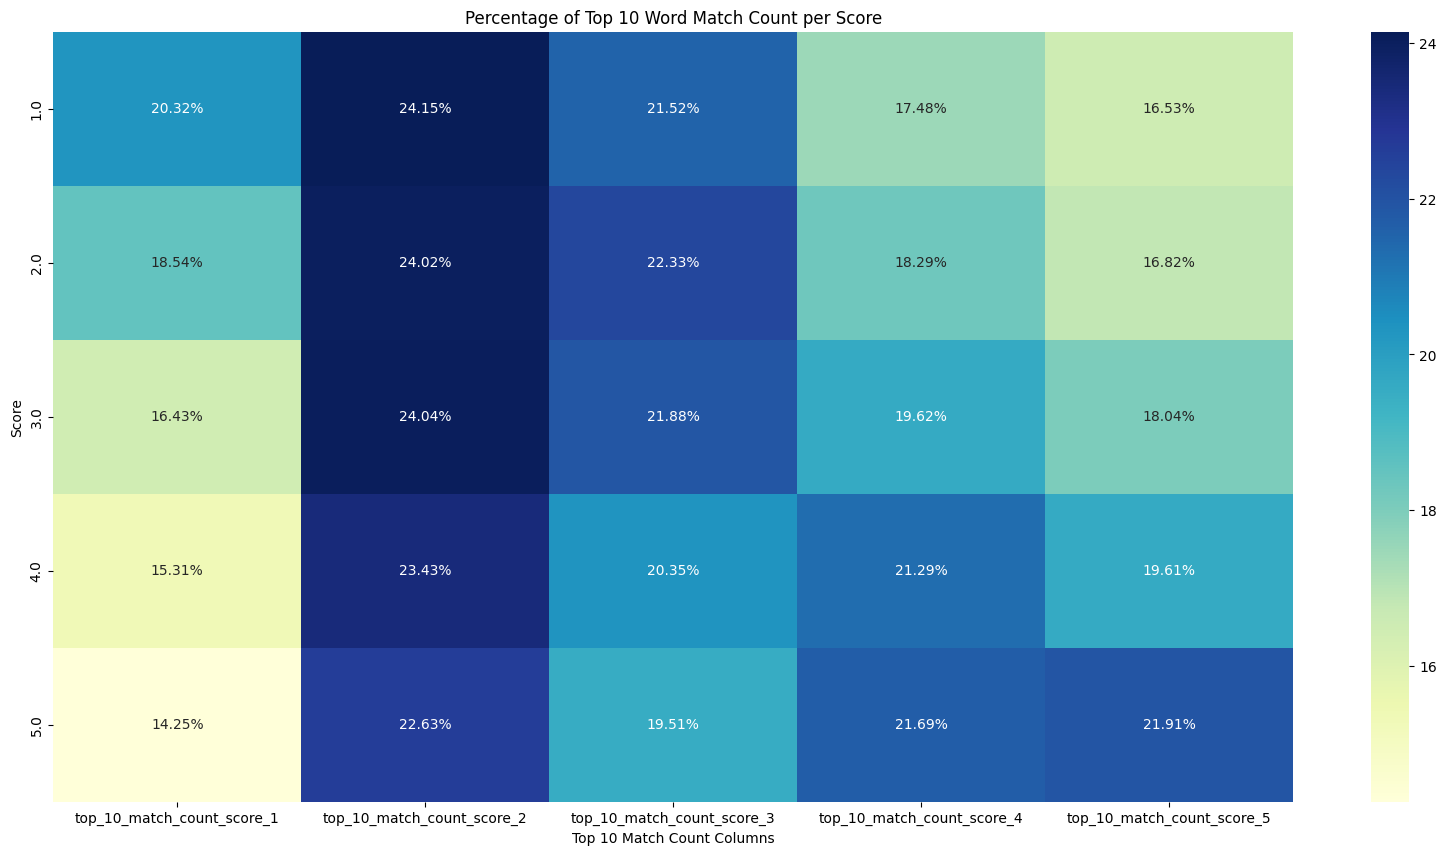

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_score_relationship_percentage(df, score_col='Score'):
    """
    Plots a heatmap showing the percentage relationship between scores and the average match count 
    for top words associated with each score.
    """
    # Select columns related to top 10 word match counts
    match_count_cols = [col for col in df.columns if col.startswith('top_10_match_count_score_')]
    
    # Calculate mean match count for each score and normalize by row to get percentages
    mean_counts = df.groupby(score_col)[match_count_cols].mean()
    percentage_counts = mean_counts.div(mean_counts.sum(axis=1), axis=0) * 100

    # Format the annotations to include '%' sign
    annot = percentage_counts.applymap(lambda x: f"{x:.2f}%")

    # Plot heatmap with percentage format
    plt.figure(figsize=(20, 10))
    sns.heatmap(percentage_counts, annot=annot, fmt='', cmap='YlGnBu')
    plt.title('Percentage of Top 10 Word Match Count per Score')
    plt.xlabel('Top 10 Match Count Columns')
    plt.ylabel('Score')
    plt.show()

# Run the function to visualize the percentage relationship
plot_score_relationship_percentage(temp_trainingSet_Summary, score_col='Score')

In [168]:
import pandas as pd
from collections import Counter
from itertools import tee, islice

# Main function to run all text analysis steps with single words and bigrams
def analyze_text_data(df, score_col='Score', text_col='Text', sample_size=10000):
    # Helper functions
    def preprocess_data(df, score_col, sample_size):
        return df.dropna(subset=[score_col]).iloc[:sample_size].copy()

    def generate_bigrams(words):
        # Generate bigrams as tuples
        first, second = tee(words)
        next(second, None)
        return zip(first, second)
    
    def get_top_words(df, score_col, text_col, stop_words):
        word_clouds = {score: Counter() for score in range(1, 6)}
        
        # Process rows to build word counts for each score
        def process_row_text(row):
            if isinstance(row[text_col], str):
                words = [word for word in row[text_col].lower().split() if word not in stop_words]
                bigrams = list(generate_bigrams(words))
                word_clouds[row[score_col]].update(words + bigrams)
        
        df.apply(process_row_text, axis=1)
        # Collect top 10 single words and bigrams for each score
        return {
            score: [word for word, _ in counter.most_common(20)] 
            for score, counter in word_clouds.items()
        }

    def add_match_count_columns(df, text_col, top_words, stop_words):
        # Adds match count columns for each score's top words and bigrams
        def process_row_match_count(row):
            if isinstance(row[text_col], str):
                words = [word for word in row[text_col].lower().split() if word not in stop_words]
                bigrams = list(generate_bigrams(words))
                words_and_bigrams = set(words + bigrams)  # Combine single words and bigrams
                
                for score in range(1, 6):
                    row[f'top_10_match_count_score_{score}'] = sum(
                        word in top_words[score] for word in words_and_bigrams
                    )
            return row

        return df.apply(process_row_match_count, axis=1)

    # Define stop words
    stop_words = set([
        'the', 'a', 'an', 'and', 'or', 'but', 'if', 'then', 'else', 'for', 'of', 'with', 'without', 'in', 'out',
        'on', 'off', 'over', 'under', 'movie', 'this', 'not', 'is', 'i', 'to', 'it', 'what', 'as', 'at', 'so',
        'we', 'by', 'that', 'are', '-', 'was', 'you', 'his', 'he', 'they', 'who', 'all', 'have', 'be', 'like',
        'from', 'film', 'one', 'just', 'about', 'no', 'would', "it's", 'my', 'even', 'there', 'has', 'when', 'only',
        'more', 'some', 'her', 'very', 'will', 'their', 'do', 'which', 'me', 'were', 'can', 'could', 'should',
        'would', 'might', 'must', 'may', 'had', 'having', 'here', 'where', 'why', 'whoever', 'whatever', 'whenever',
        'however', 'such', 'more', 'less', 'than', 'too', 'both', 'each', 'either', 'neither', 'any', 'every', 'those',
        'these', 'what', 'this', 'that', 'there', 'then', 'so', 'now', 'up', 'down', 'back', 'out', 'in', 'about', 
        'over', 'after', 'before', 'during', 'until', 'since', 'while', 'like', 'off', 'along', 'against', 
        'through', 'during', 'among', 'at', 'by', 'for', 'into', 'to', 'with', 'of', 'on', 'from', 'as', 
        'like', 'then', 'but', 'or', 'and', 'if', 'so', 'not', 'yes', 'no', 'why', 'what', 'when', 'where', 
        'how', 'do', 'does', 'did', 'is', 'are', 'was', 'were', 'be', 'been', 'having', 'could', 'should', 
        'might', 'must', 'want', 'wanting', 'need', 'needing', 'know', 'knowing', 'like', 'such', 'more', 
        'less', 'same', 'different', 'because', 'make', 'see', 'good', 'really', 'much', 'get', 'first', 'other', 'most', 'also', 'its', 'time', 'many', 'she', 'it.', 'dvd',
        'story', 'two', 'think', 'being', 'them', 'your', 'people', 'him', 'watch', 'movie.', 'made',
        'way', 'movies', 'movie,', 'films', 'character', 'characters', 'something', 'seen', 'still', 'ever', 'little'
    ])

    # Step-by-step execution
    df = preprocess_data(df, score_col, sample_size)
    top_words = get_top_words(df, score_col, text_col, stop_words)
    df = add_match_count_columns(df, text_col, top_words, stop_words)
    
    # Display top words and bigrams for each score
    for score, words in top_words.items():
        print(f"Top 10 words/bigrams for score {score}: {words}")
    
    return df

# Delete existing columns for match counts if they exist
for col in trainingSet.columns:
    if col.startswith('top_10_match_count_score_'):
        del trainingSet[col]

# Run analysis
temp_trainingSet_Text = analyze_text_data(trainingSet, score_col='Score', text_col='Text')

# Verify by printing a sample of rows
print(temp_trainingSet.iloc[10:20].to_string())


Top 10 words/bigrams for score 1: ["don't", 'bad', "didn't", 'better', "i'm", 'never', 'love', 'acting', "can't", 'great', 'waste', 'am', 'money', 'film.', 'go', 'watching', 'another', 'say', 'thought', 'buy']
Top 10 words/bigrams for score 2: ["don't", 'never', 'great', "didn't", "doesn't", 'better', 'going', "i'm", 'bad', 'nothing', 'original', 'another', 'acting', 'plot', 'few', 'go', 'watching', 'new', 'scenes', 'got']
Top 10 words/bigrams for score 3: ['great', "don't", 'well', 'better', 'pretty', 'never', "didn't", 'bad', 'plot', 'love', 'say', 'best', 'seems', 'series', "doesn't", 'show', 'bit', 'acting', 'new', 'scenes']
Top 10 words/bigrams for score 4: ['great', 'well', "don't", 'best', 'love', 'new', 'never', 'better', 'find', 'show', 'quite', 'makes', 'lot', 'another', 'few', 'bit', 'own', "i'm", 'man', 'pretty']
Top 10 words/bigrams for score 5: ['great', 'love', 'best', 'well', 'never', 'show', 'series', '&', 'new', "don't", 'season', 'watching', 'life', 'better', 'set', 

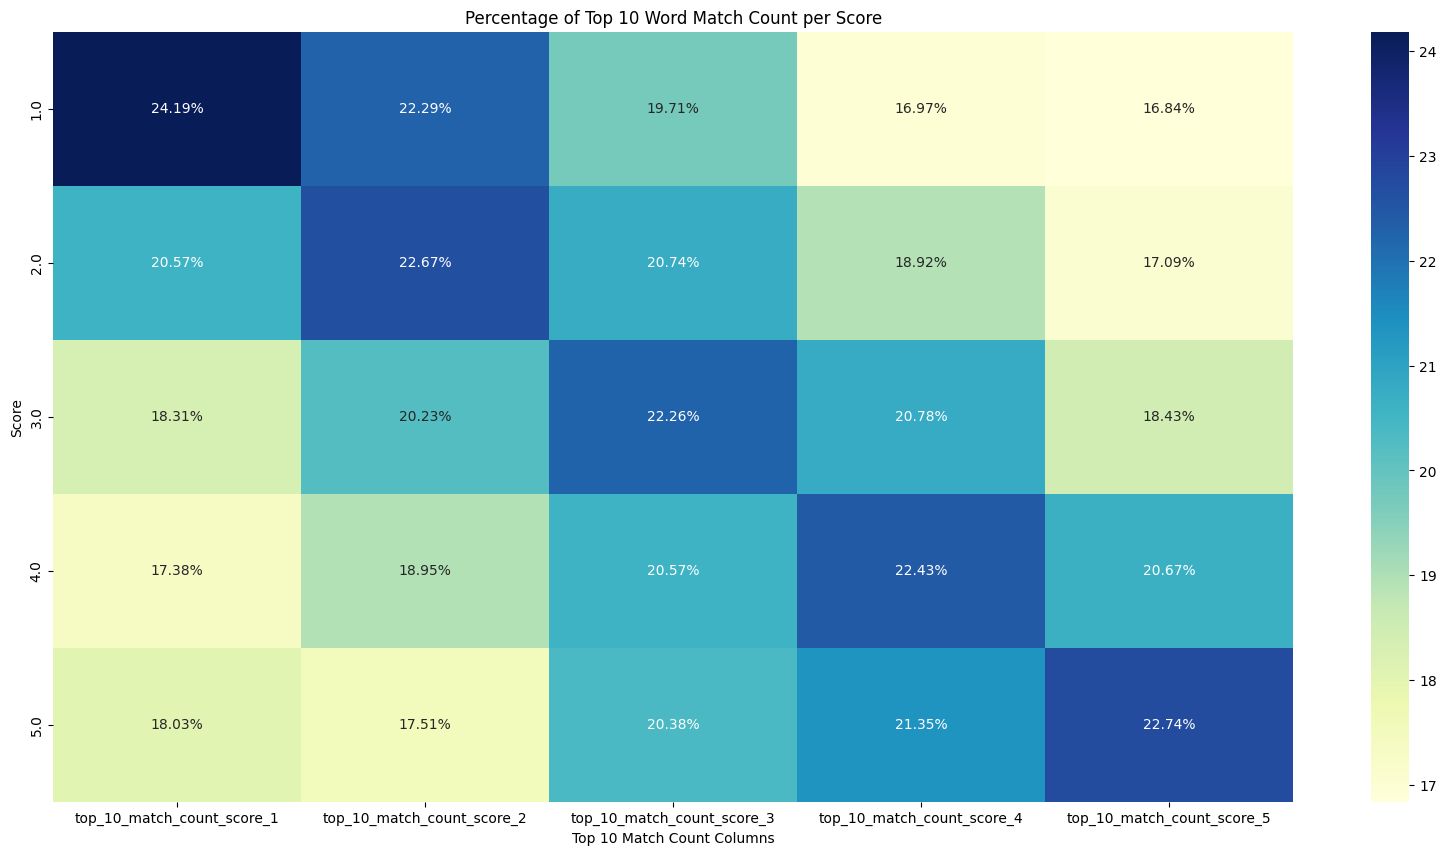

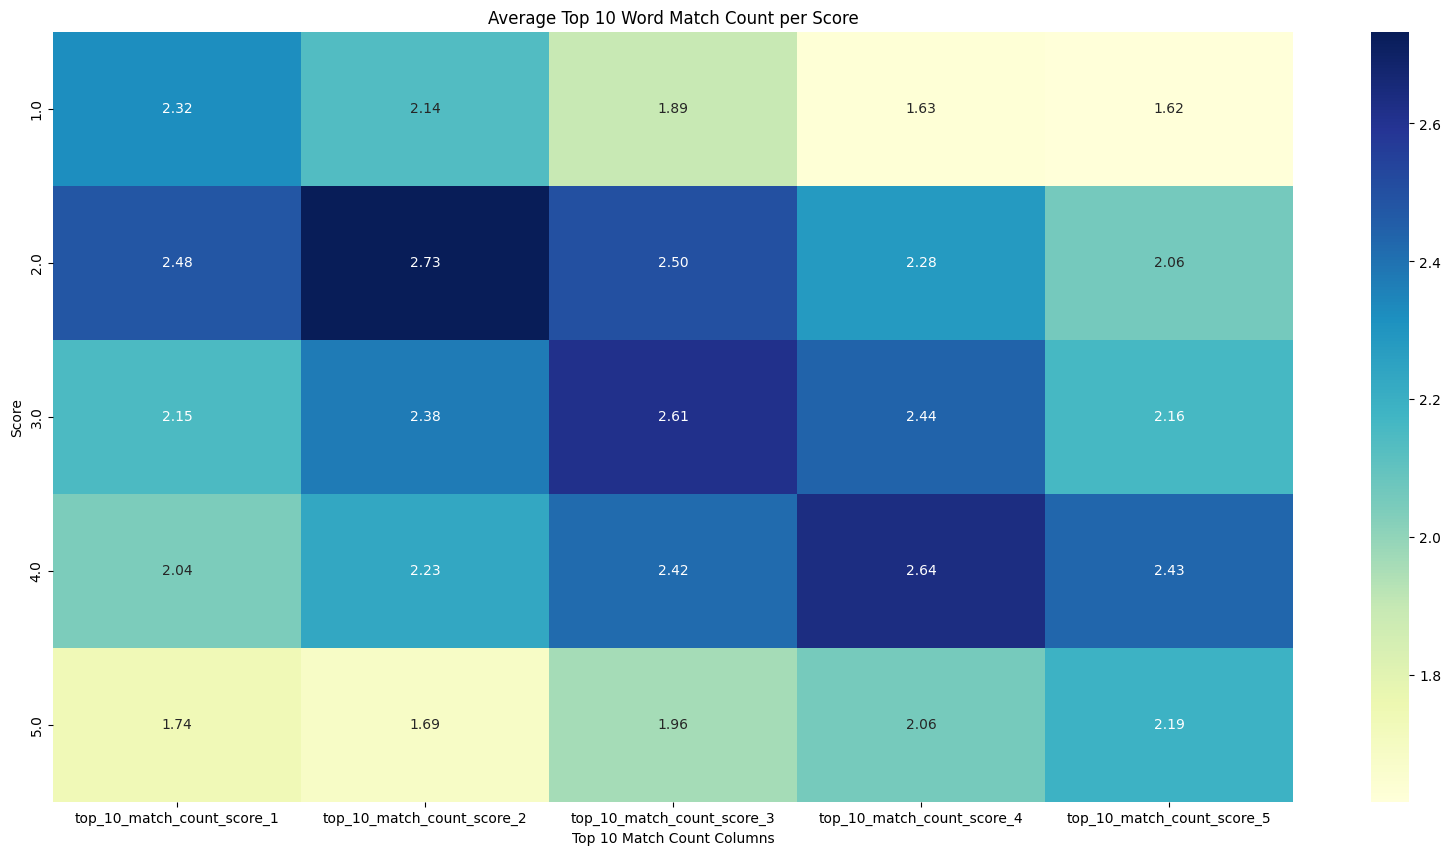

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_score_relationship_percentage(df, score_col='Score'):
    """
    Plots a heatmap showing the percentage relationship between scores and the average match count 
    for top words associated with each score.
    """
    # Select columns related to top 10 word match counts
    match_count_cols = [col for col in df.columns if col.startswith('top_10_match_count_score_')]
    
    # Calculate mean match count for each score and normalize by row to get percentages
    mean_counts = df.groupby(score_col)[match_count_cols].mean()
    percentage_counts = mean_counts.div(mean_counts.sum(axis=1), axis=0) * 100

    # Format the annotations to include '%' sign
    annot = percentage_counts.applymap(lambda x: f"{x:.2f}%")

    # Plot heatmap with percentage format
    plt.figure(figsize=(20, 10))
    sns.heatmap(percentage_counts, annot=annot, fmt='', cmap='YlGnBu')
    plt.title('Percentage of Top 10 Word Match Count per Score')
    plt.xlabel('Top 10 Match Count Columns')
    plt.ylabel('Score')
    plt.show()

def plot_score_relationship_average(df, score_col='Score'):
    """
    Plots a heatmap showing the average match count for top words associated with each score.
    """
    # Select columns related to top 10 word match counts
    match_count_cols = [col for col in df.columns if col.startswith('top_10_match_count_score_')]
    
    # Calculate the mean match count for each score
    mean_counts = df.groupby(score_col)[match_count_cols].mean()

    # Plot heatmap of average match counts
    plt.figure(figsize=(20, 10))
    sns.heatmap(mean_counts, annot=True, fmt='.2f', cmap='YlGnBu')
    plt.title('Average Top 10 Word Match Count per Score')
    plt.xlabel('Top 10 Match Count Columns')
    plt.ylabel('Score')
    plt.show()

# Run the function to visualize the percentage relationship
plot_score_relationship_percentage(temp_trainingSet_Text, score_col='Score')

# Run the function to visualize the average relationship
plot_score_relationship_average(temp_trainingSet_Text, score_col='Score')


# Adding Features

In [3]:
def add_basic_features(df, verbose=True):
    """Add basic text and temporal features to the dataframe."""
    features_df = df.copy()
    
    if verbose:
        print("\nAdding features...")
        time.sleep(0.1)  # Ensure print statement is visible# Add Helpfulness feature first
    
    print("\nCalculating Helpfulness score...")
    features_df['Helpfulness'] = features_df['HelpfulnessNumerator'] / features_df['HelpfulnessDenominator']
    features_df['Helpfulness'] = features_df['Helpfulness'].fillna(0)
    
    def count_special_chars(text, char):
        """Safely count special characters in text"""
        if pd.isna(text):
            return 0
        return str(text).count(char)

    def count_punctuation(text):
        """Safely count all punctuation in text"""
        if pd.isna(text):
            return 0
        return sum(str(text).count(p) for p in '.,!?;:')

    feature_groups = [
        ("Text length features", [
            ('text_length', lambda df: df['Text'].fillna('').str.len()),
            ('summary_length', lambda df: df['Summary'].fillna('').str.len()),
            ('word_count', lambda df: df['Text'].fillna('').str.split().str.len()),
            ('summary_word_count', lambda df: df['Summary'].fillna('').str.split().str.len())
        ]),
        ("Punctuation features", [
            ('exclamation_count', lambda df: df['Text'].apply(lambda x: count_special_chars(x, '!'))),
            ('question_count', lambda df: df['Text'].apply(lambda x: count_special_chars(x, '?'))),
            ('punctuation_count', lambda df: df['Text'].apply(count_punctuation))
        ]),
        ("Case features", [
            ('uppercase_word_count', lambda df: df['Text'].fillna('').apply(
                lambda x: sum(1 for word in str(x).split() if word.isupper()))),
            ('uppercase_ratio', lambda df: None)  # Will be calculated after word_count
        ]),
        ("Temporal features", [
            ('year', lambda df: pd.to_datetime(df['Time'], unit='s').dt.year),
            ('month', lambda df: pd.to_datetime(df['Time'], unit='s').dt.month),
            ('day_of_week', lambda df: pd.to_datetime(df['Time'], unit='s').dt.dayofweek),
            ('is_weekend', lambda df: pd.to_datetime(df['Time'], unit='s').dt.dayofweek.isin([5, 6]).astype(int))
        ])
    ]
    
    if verbose:
        pbar = tqdm(total=len(feature_groups), desc="Feature Groups Progress")
    
    for group_name, features in feature_groups:
        if verbose:
            time.sleep(0.1)  # Ensure progress bar updates are visible
            print(f"\nProcessing {group_name}...")
        
        for feature_name, feature_func in features:
            if feature_name == 'uppercase_ratio':
                features_df['uppercase_ratio'] = features_df['uppercase_word_count'] / features_df['word_count']
                features_df['uppercase_ratio'] = features_df['uppercase_ratio'].fillna(0)
            else:
                features_df[feature_name] = feature_func(features_df)
        
        if verbose:
            pbar.update(1)
    
    if verbose:
        pbar.close()
        print("\nFeature addition completed!")
    
    return features_df

In [4]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train2 = add_basic_features(trainingSet)
    train3 = add_features_to(train2)
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [5]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [6]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [7]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=3).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.40944319968976883


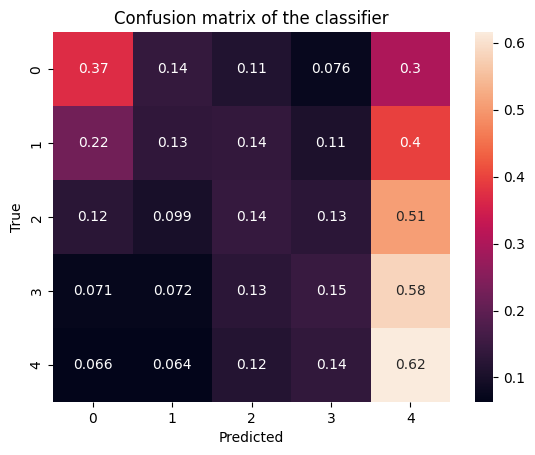

In [8]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.show()

# Create submission file

In [9]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)